In [1]:
from tqdm import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
import math
from matplotlib import pyplot
import numpy as np
from numpy import inf

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
from pathlib import Path
import requests
import pickle
import struct
import gzip
import io
import time

In [3]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

m = nn.AvgPool2d(2, stride=2)
x_train = m(x_train.reshape((50000, 28, 28))).reshape((50000, 14 * 14))
x_valid = m(x_valid.reshape((10000, 28, 28))).reshape((10000, 14 * 14))

In [4]:
class STE_Round(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Because we are saving one of the inputs use `save_for_backward`
        # Save non-tensors and non-inputs/non-outputs directly on ctx
        return torch.round(x)

    @staticmethod
    def backward(ctx, grad_out):
        # A function support double backward automatically if autograd
        # is able to record the computations performed in backward
        return grad_out

def Q(x, s, z, alpha_q, beta_q):
  # WARNING TORCH.ROUND BACKPROP GIVES 0, SHOULD USE STE
  x_q = STE_Round.apply(1/s*x+z)
  #x_q = 1/s * x + z
  return torch.clamp(x_q, min=alpha_q, max=beta_q)

def Q_int8(x, s, z):
  x_q = Q(x, s, z, alpha_q = -127, beta_q = 127)
  return x_q

def Q_uint8(x, s, z):
  x_q = Q(x, s, z, alpha_q = 0, beta_q = 255)
  return x_q

def Q_inv(x_q, s, z):
  return s * (x_q - z)

def Q_matmul_s_only(x, w, s_x, s_w):
  return (x @ w) * s_x * s_w

def FQ_int8(x, s, z):
  return Q_inv(Q_int8(x, s, z), s, z)

def FQ(x, s, z, bins):
  return Q_inv(Q(x, s, z, alpha_q = -bins, beta_q = bins), s, z)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 196])
tensor(0) tensor(9)
torch.Size([50000, 196])
torch.Size([10000, 196])


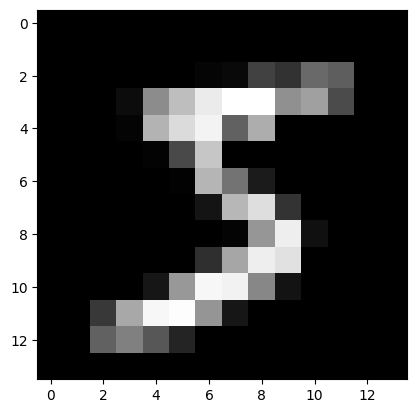

In [5]:
bs = 64  # batch size

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

pyplot.imshow(x_train[0].reshape((round(math.sqrt(c)), round(math.sqrt(c)))), cmap="gray")
print(x_train.shape)
print(x_valid.shape)

In [6]:
x_train = Q_int8(x_train, torch.max(torch.abs(x_train))/(16-1), 0)
x_valid = Q_int8(x_valid, torch.max(torch.abs(x_valid))/(16-1), 0)

In [7]:
x_train[0].detach().numpy().astype(np.uint8)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  4,  3,  6,  6,  0,  0,  0,  0,  0,  1,  8, 11, 14, 15, 15,
        8,  9,  4,  0,  0,  0,  0,  0,  0, 10, 13, 14,  6, 10,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  4, 12,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 11,  7,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1, 11, 13,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  9, 14,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3, 10, 14, 13,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  9, 14, 14,  8,  1,  0,  0,  0,
        0,  0,  0,  3, 10, 14, 15,  9,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        6,  7,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=uint8)

In [8]:
x_train[0].size()

torch.Size([196])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])


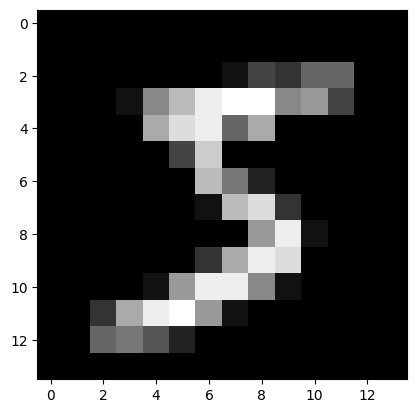

In [9]:
pyplot.imshow(x_train[0].reshape((14, 14)), cmap="gray")
print(x_train, y_train)

In [10]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [11]:
x = torch.randn(size=(1,1))
buff = io.BytesIO()
buff.write((255).to_bytes(3, 'little'))
buff.seek(0)  # <--  this is what you were missing
print(f'buffer: {buff.read()}')
print(f'buffer: {buff.getvalue()}')

#torch.save(x, buff)
#buff.seek(0)  # <--  this is what you were missing
#print(f'buffer: {buff.read()}')
print(buff.writable())

buffer: b'\xff\x00\x00'
buffer: b'\xff\x00\x00'
True


In [12]:
def cumul_inverse(cumul_counts):
  lut = np.zeros(shape=(cumul_counts[-1]), dtype = int)
  j = 0
  for i in range(cumul_counts[-1]):
    if i < cumul_counts[j]:
      lut[i] = j-1
    else:
      j += 1
      lut[i] = j-1

  return lut

def h(x):
  bits = np.log2(x)
  bits[bits == -inf] = 0
  return bits*-x

def C_rANS(input, state, symbol_counts, total_counts, cumul_counts):
  s_count = symbol_counts[input] # current symbol count/frequency
  next_state = (state//s_count)*total_counts + cumul_counts[input] + (state % s_count)
  return next_state

def D_rANS(state, symbol_counts, total_counts, cumul_counts, cumul_inv_f):
  slot = state % total_counts # compute the slot
  s = cumul_inv_f[slot] # decode the symbol
  prev_state = (state//total_counts)*symbol_counts[s] + slot - cumul_counts[s] # update the state
  return s, prev_state

def Streaming_rANS_encoder(s_input, symbol_counts):
  bits = 8
  total_counts = np.sum(symbol_counts)  # Represents M
  cumul_counts = np.insert(np.cumsum(symbol_counts),0,0) # the cumulative frequencies
  bitstream = io.BytesIO() # initialize stream
  state = total_counts # state initialized to M
  #bitmask = 2**bits-1
  max_range = symbol_counts * (2**bits)

  for s in reversed(s_input): # iterate over the input
    # Output bits to the stream to bring the state in the range for the next encoding
    while state >= max_range[s]:
      bitstream.write(state.astype(np.uint8).tobytes())
      state = state >> bits
    state = C_rANS(s, state, symbol_counts, total_counts, cumul_counts) # The rANS encoding step

  bitstream.write(state.item().to_bytes(3, 'little'))

  retObj = bytes(reversed(bitstream.getvalue()))
  bitstream.close()
  return retObj

def Streaming_rANS_decoder(bitstream, size, symbol_counts):
  data = np.zeros(shape=(size), dtype = np.uint8)
  total_counts = np.sum(symbol_counts)  # Represents M
  cumul_counts = np.insert(np.cumsum(symbol_counts),0,0) #the cumulative frequencies
  cumul_inv_f = cumul_inverse(cumul_counts)
  i = 0
  j = 3
  streamLen = len(bitstream)
  state = int.from_bytes(bitstream[0:3], 'big')

  while (j < streamLen) or (state != total_counts):
    # perform the rANS decoding
    s, state = D_rANS(state, symbol_counts, total_counts, cumul_counts, cumul_inv_f)

    # remap the state into the acceptable range
    while (j < streamLen) and (state < total_counts):
      stream = bitstream[j]
      j += 1
      state = (state << 8) + stream

    data[i] = s
    i += 1

  return data

In [13]:
def gen_sample(symbol_counts, size, seed = 42):
  # Generate uniform RNG, then bin it accordingly
  rng = np.random.default_rng(seed=seed)
  rints = rng.integers(low=0, high=sum(symbol_counts), size=size)
  cum_sum = np.insert(np.cumsum(symbol_counts),0,0)
  table = cumul_inverse(cum_sum)
  return list(map(lambda i: table[i], rints))

def compress_nparr(nparr, bins):
  # 1. Generate byte bins & symbol count to pass into
  (hist, t) = np.histogram(nparr, bins = bins)
  pyplot.stairs(hist, t)
  print(hist, len(hist))

  # round the freq distribution with sum equal to 256
  hist = np.ceil(hist/np.sum(hist)*256).astype(np.int32)
  err = 256 - np.sum(hist)
  hist[np.argmax(hist)] += err

  # make the zeros one
  hist[hist == 0] = 1
  err = 256 - np.sum(hist)
  hist[np.argmax(hist)] += err

  print(hist, len(hist))

  assert(np.sum(hist) == 256)

  # 2. Transform the input into uint8
  new_nparr = nparr.flatten() - np.min(nparr)
  print(np.min(new_nparr), np.max(new_nparr))

  # 3. Compress
  # WARNING: DO NOT PASS A SYMBOL WITH ZERO FREQUENCY, IT WILL INF LOOP
  # TEMPORARY FIX: +1 TO THE 0 FREQ SYM AND SUBTRACT MAX FREQ SYM
  bitstream = Streaming_rANS_encoder(new_nparr.view(np.uint8), hist)
  return (hist, bitstream)

  '''
  # 1. Generate byte bins & symbol count to pass into
  (hist, _) = np.histogram(nparr, bins = bins)
  err = 256 - np.sum(hist)
  hist[np.argmax(hist)] += err
  assert(np.sum(hist) == 256)

  # 2. Transform the input into uint8
  nparr = nparr.view(np.uint8) - np.min(nparr)

  # 3. Compress
  Streaming_rANS_encoder(nparr, hist)

  return (hist, bitstream)
  '''

In [14]:
# Bin according to symbol_count distribution
symbol_counts = np.array([5, 1, 2])
size = 1024**2

rand_samp = gen_sample(symbol_counts, size)
counts, bins = np.histogram(rand_samp, bins = len(symbol_counts))

print(sum(symbol_counts), counts, bins)
original_bits = np.log(3)/np.log(2)
compress_bits = sum(h(np.array(symbol_counts)/8))
print("Per element original bits: ", original_bits)
print("Per element compressed bits: ", compress_bits)
print("Ideal Total Bytes: ", compress_bits*size/8)
print("Ideal Ratio: ", compress_bits/original_bits)

8 [655749 131169 261658] [0.         0.66666667 1.33333333 2.        ]
Per element original bits:  1.5849625007211563
Per element compressed bits:  1.2987949406953985
Ideal Total Bytes:  170235.65046682727
Ideal Ratio:  0.8194483718728034


In [15]:
bitstream = Streaming_rANS_encoder(rand_samp, symbol_counts)
out_symbols = Streaming_rANS_decoder(bitstream, size, symbol_counts)
print(all(out_symbols == rand_samp))

True


In [16]:
original_bytes = np.log(3)/np.log(2)*size/8
print("Original: ", original_bytes, "bytes")
print("Compressed: ", len(bitstream), "bytes")
print("Compression Ratio: ", len(bitstream)/original_bytes)

Original:  207744.2048945234 bytes
Compressed:  170820 bytes
Compression Ratio:  0.8222612038045987


In [17]:
rng = np.random.default_rng()
rand_num = rng.random(size = 1, dtype = np.float32)
print(rand_num[0])
(tmp) = struct.pack('<f', rand_num[0]) # actually a float32
tmp = bytearray(tmp)
print(struct.unpack('<f', tmp)[0])
tmp[0]=0
print(struct.unpack('<f', tmp)[0])
tmp[1]=0
print(struct.unpack('<f', tmp)[0])

0.24302459
0.24302458763122559
0.24302291870117188
0.2421875


In [18]:
# OPCODE, 32 max currently
OP_BEGIN = 0
OP_END = 1
OP_MATMUL = 2

OP_MATRIX_MAX = 4
OP_MATRIX_ADD = 5

OP_QUANTIZE = 8
OP_DEQUANTIZE = 9

FILE_VERSION = 0

class op:
  def __init__(self, opcode, data, prev = None):
    self.opcode = opcode

    self.prev = prev
    self.next = None

    # Initialize buffer if there are no previous links (a begin node)
    if prev:
      (self.op_buf, self.weight_buf, self.data_buf) = prev.link_next(self)
    else:
      self.op_buf = io.BytesIO()
      self.weight_buf = io.BytesIO()
      self.data_buf = io.BytesIO()

    # Create tensor object to emit different data and weight bitstreams
    if (opcode == OP_BEGIN) or (opcode == OP_END):
      self.tensor = tensor(data, self.data_buf)
    elif (opcode == OP_QUANTIZE) or (opcode == OP_DEQUANTIZE):
      self.tensor = data
    else:
      self.tensor = tensor(data, self.weight_buf)

  def emit(self):
    self.op_buf.write(self.opcode.to_bytes(1, 'little'))

    if (self.opcode == OP_QUANTIZE) or (self.opcode == OP_DEQUANTIZE):
      # directly store scalar
      (tmp) = struct.pack('<f', self.tensor) # actually a float32
      self.op_buf.write(tmp[1:3])
    else:
      self.op_buf.write(self.tensor.buf.tell().to_bytes(3, 'little'))
      self.tensor.emit()
    if self.next:
      self.next.emit()

    if (self.opcode == OP_BEGIN):
      retObj = (self.op_buf.getvalue(), self.weight_buf.getvalue(), self.data_buf.getvalue())
      self.op_buf.close()
      self.weight_buf.close()
      self.data_buf.close()
      return retObj

  def link_next(self, next):
    self.next = next
    return self.op_buf, self.sram_buf, self.flash_buf

class tensor:
  '''
  '''
  def __init__(self, tensor, buf):
    self.tensor = tensor
    self.buf = buf
    dim = tensor.shape
    if len(dim) == 0:
      self.x = 1
      self.y = 1
    elif len(dim) == 1:
      self.x = dim[0]
      self.y = 1
    elif len(dim) == 2:
      self.x = dim[0]
      self.y = dim[1]
    else:
      raise Exception("Unsupported dimention")

  def emit(self):
    # always use int8 for now
    dtype = 0

    # Only compress if is large enough
    # 0: dense, 1: huffman, 2: ANS, 3: custom
    codec = 1 if (self.x*self.y > 256) else 0

    # codec (2), dtype (2), bin (4)
    self.buf.write(((0<<6)|(0<<4)|(0)).to_bytes(1, 'little'))
    self.buf.write(self.x.to_bytes(2, 'little'))
    self.buf.write(self.y.to_bytes(2, 'little'))
    # Dense or compressed
    if (codec == 0):
      self.buf.write((self.x*self.y).to_bytes(3, 'little'))
      self.buf.write(self.tensor.numpy().tobytes())
    else: # (codec == 1): compressed
      compress_nparr(self.tensor.numpy(), 16)

In [19]:
def exportCArray(bitstream):
  buf = io.StringIO()
  buf.write('{')
  buf.write(', '.join(map(hex, bitstream)))
  buf.write('}')
  retObj = buf.getvalue()
  buf.close()
  return retObj

In [20]:
class FC_Q(nn.Module):
  def __init__(self, x_size, y_size):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(x_size, y_size) / math.sqrt(x_size))
    self.bias = nn.Parameter(torch.zeros(y_size))
    self.s_x = lambda bits: 2*self.max_x/bits
    self.max_x = 0.0
    self.s_w = lambda bits: 2*torch.max(torch.abs(self.weights))/bits
    self.s_b = lambda bits: 2*torch.max(torch.abs(self.bias))/bits

  def forward(self, xb, train = True, w_bits = 256, x_bits = 256):
    if train:
      # QAT for weight only, find the max range of input over training
      curr = torch.max(torch.abs(xb))
      self.max_x = curr if (curr > self.max_x) else self.max_x
      return (xb @ FQ_int8(self.weights, self.s_w(w_bits), 0)) + self.bias
    else:
      # Use int8
      Q_xb = Q_int8(xb, self.s_x(x_bits), 0).type(torch.int8)
      return (Q_xb @ self.Q_w(w_bits)).type(torch.float) * self.s_x(x_bits) * self.s_w(w_bits) + self.Q_b(x_bits) * self.s_b(x_bits)

  def Q_w(self, bits):
    return Q_int8(self.weights, self.s_w(bits), 0).type(torch.int8)

  def Q_b(self, bits):
    return Q_int8(self.bias, self.s_b(bits), 0).type(torch.int8)

class MNIST_Model_Q(nn.Module):
  def __init__(self, h1):
    super().__init__()
    self.l1 = FC_Q(c, h1)
    self.l2 = FC_Q(h1, 10)
    #self.l3 = FC_Q(10, 10)

  def forward(self, xb, train = True, L1_w = 256, L1_x = 256, L2_w = 256, L2_x = 256):
    act = torch.nn.ReLU6()
    out_act = torch.nn.Softmax(dim=1)
    L1 = act(self.l1(xb, train, L1_w, L1_x))
    L2 = self.l2(L1, train, L2_w, L2_x)
    '''
    if verbose:
      print(torch.transpose(Q_int8(L1, self.l2.s_x(L2_bits), 0).type(torch.uint8), 0, 1))
      print(torch.transpose(L2, 0, 1))
    '''
    return out_act(L2)

  def compile(self, input, output, L1_bits = 8, L2_bits = 8):
    begin = op(OP_BEGIN, input.to(torch.int8))
    next = op(OP_MATMUL, self.l1.s_w(self.w_bits).to(torch.int8), begin)
    next = op(OP_MATRIX_ADD, input.to(torch.int8), next)
    next = op(OP_DEQUANTIZE, input.to(torch.int8), next)

    next = op(OP_MATRIX_MAX, input.to(torch.int8), next)

    next = op(OP_QUANTIZE, torch.tensor(1, dtype=torch.float32), next)
    next = op(OP_MATMUL, input.to(torch.int8), next)
    next = op(OP_MATRIX_ADD, input.to(torch.int8), next)
    next = op(OP_DEQUANTIZE, input.to(torch.int8), next)

    op(OP_END, output.to(torch.int8), next)

    return begin.emit()

In [21]:
lr = 0.001  # learning rate
epochs = 20  # how many epochs to train for
loss_func = F.cross_entropy
hidden_dim = 64

def get_model():
    model = MNIST_Model_Q(hidden_dim)
    return model, optim.Adam(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(x_valid[0:bs]), y_valid[0:bs]))

tensor(2.3289, grad_fn=<NllLossBackward0>)


In [22]:
# Create fit() and get_data()
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        if (epoch % 5 == 0):
            model.eval()
            with torch.no_grad():
                losses, nums = zip(
                    *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
                )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(epoch, val_loss)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.5333365091323852
5 1.4989413999557495
10 1.4960229373931884
15 1.4930312063217164


In [23]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean().item()

def correct_index(out, yb):
    preds = torch.argmax(out, dim=1)
    return torch.nonzero((preds == yb), as_tuple = True)

In [24]:
L1_bits = 6 # 5 for 28*28, 9 for 14*14
L2_bits = 8
print("Unquantized accuracy", accuracy(model(x_valid), y_valid), "%")
print("Quantized accuracy int8", accuracy(model(x_valid, train = False,
                                                L1_w = 16, L1_x = 2,
                                                L2_w = 12, L2_x = 4),
                                          y_valid), "%")
print("Quantized accuracy int8", accuracy(model(x_valid, train = False,
                                                L1_w = 14, L1_x = 10,
                                                L2_w = 8, L2_x = 7),
                                          y_valid), "%")

Unquantized accuracy 0.9696000218391418 %
Quantized accuracy int8 0.8702999949455261 %
Quantized accuracy int8 0.9487000107765198 %


In [25]:
print("Quantized accuracy int8", accuracy(model(x_valid, train = False,
                                                L1_w = 16, L1_x = 8,
                                                L2_w = 16, L2_x = 4),
                                          y_valid), "%")

Quantized accuracy int8 0.9562000036239624 %


In [26]:
bits = 4
num_bins = 2**bits

[4917  111   95   80   86   85   96   80   81   91   71   79   92   99
   91  118] 16
[194   5   4   4   4   4   4   4   4   4   3   4   4   5   4   5] 16
0 15


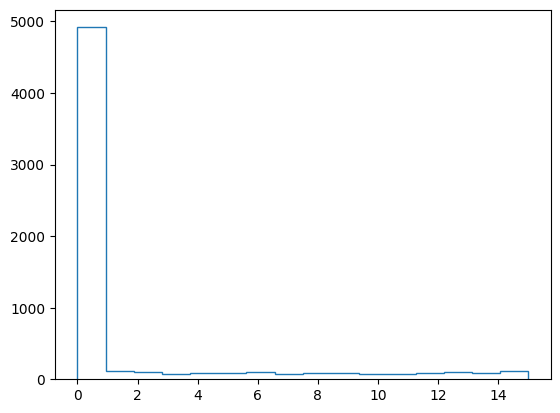

In [27]:
(dist, bitstream) = compress_nparr(x_valid[0:32].detach().numpy().astype(np.int8), 16)

In [28]:
x_valid[0:32].size()

torch.Size([32, 196])

In [29]:
decompressed = np.array(Streaming_rANS_decoder(bitstream, 32*14*14, dist))

In [30]:
exportCArray(bitstream)

'{0x0, 0x4, 0x60, 0x6c, 0x4a, 0xf6, 0xd4, 0x37, 0xd2, 0xdd, 0xf4, 0x45, 0x67, 0x46, 0x65, 0xed, 0x99, 0xf6, 0xea, 0xc6, 0x9, 0xfe, 0x41, 0xd8, 0xef, 0xc9, 0x9, 0xf7, 0xdc, 0xb8, 0xed, 0xf7, 0xfe, 0x5d, 0x2c, 0xf3, 0xdb, 0xc6, 0x3, 0x2, 0x4c, 0xd3, 0xd9, 0xd7, 0xaa, 0xf6, 0xe2, 0xd9, 0xee, 0xca, 0x76, 0xd5, 0x32, 0xc8, 0x99, 0xea, 0x39, 0xcd, 0xb9, 0xe8, 0xe2, 0xe0, 0x9a, 0xfd, 0xce, 0x16, 0xe5, 0xc3, 0x15, 0xe8, 0x45, 0xe3, 0x6d, 0xd7, 0x91, 0x9f, 0xe1, 0xe4, 0xe5, 0x4f, 0xdb, 0x76, 0xc1, 0x27, 0xe0, 0x66, 0xf5, 0x43, 0x9b, 0xce, 0x97, 0xd3, 0x2d, 0xf9, 0xca, 0x92, 0xd7, 0x34, 0xcc, 0x69, 0x9a, 0xf9, 0xf4, 0x30, 0x59, 0xd3, 0xf2, 0x7a, 0xcb, 0xd0, 0xff, 0xea, 0xca, 0xb3, 0xf1, 0xe4, 0xcd, 0x6, 0x6, 0x2, 0x72, 0x6c, 0xd0, 0x54, 0xf0, 0xe6, 0xef, 0x3d, 0xeb, 0x25, 0xf7, 0xe4, 0x1e, 0xaf, 0xf7, 0xbf, 0xf4, 0xd7, 0xc7, 0xea, 0xce, 0x54, 0xee, 0xf0, 0xf9, 0x53, 0x6e, 0x51, 0xb1, 0x47, 0x2b, 0xcd, 0x4d, 0xd6, 0x10, 0xd0, 0x3e, 0x6b, 0xd4, 0x3d, 0xf7, 0xe4, 0xe7, 0x5e, 0x5e, 0xcd, 0x5a, 0x2b,

In [31]:
exportCArray(dist)

'{0xc2, 0x5, 0x4, 0x4, 0x4, 0x4, 0x4, 0x4, 0x4, 0x4, 0x3, 0x4, 0x4, 0x5, 0x4, 0x5}'

In [32]:
cnt = [194, 5, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 5, 4, 5]

In [33]:
cumul_counts = np.insert(np.cumsum(cnt), 0, 0)

In [34]:
cumul_counts

array([  0, 194, 199, 203, 207, 211, 215, 219, 223, 227, 231, 234, 238,
       242, 247, 251, 256])

In [35]:
cumul_inverse(cumul_counts)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,
        3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
        7,  7,  8,  8,  8

In [36]:
len(bitstream)

1248

In [37]:
len(bitstream)/(14*14*32)

0.1989795918367347

In [38]:
y_valid[0:32]

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1,
        0, 3, 0, 6, 2, 9, 9, 4])

[   9   28   62  214  478 1178 2574 3592 2604 1179  421  143   43   16
    3] 15
[ 1  1  2  5 10 25 53 65 54 25  9  3  1  1  1] 15
0 14


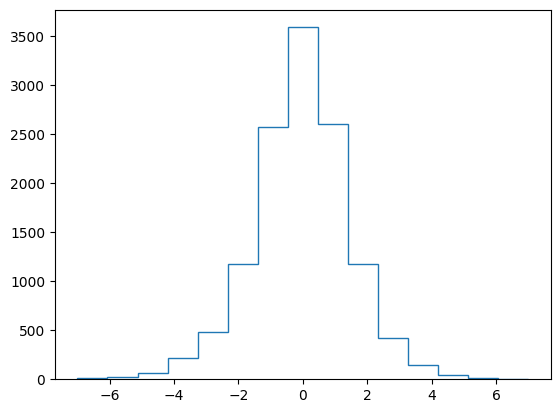

In [39]:
(dist, bitstream) = compress_nparr(model.l1.Q_w(num_bins - 2).detach().numpy(), num_bins - 1)

In [40]:
print(exportCArray(dist))

{0x1, 0x1, 0x2, 0x5, 0xa, 0x19, 0x35, 0x41, 0x36, 0x19, 0x9, 0x3, 0x1, 0x1, 0x1}


In [41]:
len(bitstream)/1024

4.2060546875

In [42]:
print(exportCArray(bitstream))

{0x0, 0x1e, 0xc9, 0x4f, 0x46, 0x14, 0xed, 0xa3, 0x33, 0x89, 0xa4, 0x7d, 0xb0, 0x3e, 0x80, 0x97, 0x63, 0x52, 0x98, 0x5a, 0x77, 0x7d, 0x88, 0x49, 0x5b, 0xcf, 0x6b, 0x96, 0x3e, 0x70, 0x65, 0x39, 0x42, 0xbf, 0x50, 0xa4, 0xc5, 0x2e, 0x4d, 0xbc, 0x97, 0x72, 0x6a, 0xec, 0xc5, 0x39, 0xa3, 0xd2, 0xa3, 0x8a, 0x98, 0x8a, 0xb1, 0x96, 0x8e, 0x6d, 0xc8, 0x6f, 0xc1, 0xb7, 0xdc, 0x82, 0x86, 0x92, 0x7d, 0x7f, 0x8a, 0x82, 0x41, 0x6e, 0xbb, 0xae, 0x96, 0xe7, 0x8c, 0x7, 0x3d, 0x6a, 0x97, 0x37, 0x3b, 0x29, 0x23, 0x79, 0x40, 0x2f, 0x2c, 0x51, 0x66, 0xd6, 0xdd, 0x1e, 0x8e, 0x19, 0x32, 0xc, 0x23, 0xa9, 0x7e, 0x86, 0xca, 0x1e, 0x46, 0xaf, 0x63, 0x62, 0x88, 0x17, 0x51, 0xa5, 0x62, 0x4d, 0x69, 0xf, 0x1b, 0x17, 0x4d, 0x5c, 0x64, 0xc7, 0x54, 0x5c, 0x14, 0x79, 0x16, 0x68, 0xb5, 0xd0, 0x4d, 0xc2, 0x4f, 0x96, 0x64, 0xcd, 0xf, 0x3a, 0xf5, 0xf1, 0x13, 0xcf, 0x6f, 0xec, 0xb2, 0x6f, 0x16, 0x11, 0x85, 0x3, 0xc6, 0x55, 0x3d, 0x58, 0xe7, 0x55, 0xc9, 0x8d, 0x4d, 0x1d, 0xd8, 0x69, 0x15, 0x81, 0xd2, 0xbd, 0x2e, 0xaa, 0xdd, 0x5

In [43]:
bitsPerWeight = sum(h(dist/sum(dist)))
KBs = bitsPerWeight * (14*14*hidden_dim) / 8 / 1024
print("Bits: ", bitsPerWeight, "KBs: ", KBs)
print("Compression gain:", bitsPerWeight / 8)

Bits:  2.851157966864385 KBs:  4.36583563676109
Compression gain: 0.35639474585804815


In [44]:
model.l1.Q_b(num_bins - 2).detach().numpy()

array([ 5, -2,  2,  3, -3,  3,  4,  7,  1,  6, -2, -2, -2, -3,  7, -1,  5,
        6, -4,  3, -1, -1,  4, -7,  2, -3, -2,  5, -1,  1,  5,  2,  1, -5,
       -2,  1, -2,  3, -1, -1,  0, -1, -3,  4,  5,  0,  0, -2,  1,  3,  0,
        3,  0,  5,  1, -2,  5,  3, -1,  3,  5,  2,  3,  2], dtype=int8)

29.310503960328617

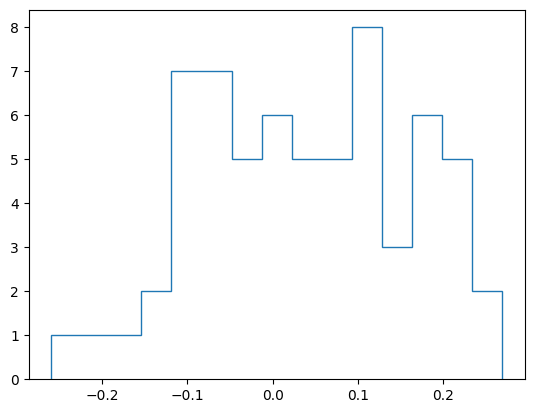

In [45]:
counts, bins = np.histogram(model.l1.bias.detach().numpy(), bins=num_bins-1)
pyplot.stairs(counts, bins)
sum(h(counts/sum(counts))) * hidden_dim / 8

[  8  11  21  34  60  69  69   0 109 118  85  37  13   4   2] 15
[ 4  5  9 14 24 28 28  1 43 42 34 15  6  2  1] 15
0 13


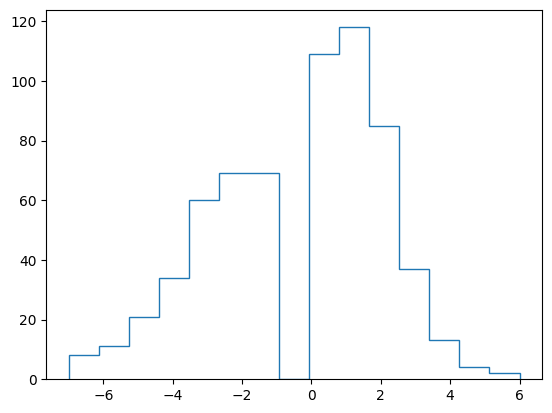

In [46]:
(dist, bitstream) = compress_nparr(model.l2.Q_w(num_bins - 2).detach().numpy(), num_bins-1)

In [47]:
print(exportCArray(dist))

{0x4, 0x5, 0x9, 0xe, 0x18, 0x1c, 0x1c, 0x1, 0x2b, 0x2a, 0x22, 0xf, 0x6, 0x2, 0x1}


In [48]:
len(bitstream)/1024

0.318359375

In [49]:
print(exportCArray(bitstream))

{0x0, 0x2c, 0x1a, 0x72, 0x66, 0xc5, 0x6e, 0x70, 0x8e, 0x40, 0xbe, 0x39, 0x70, 0x70, 0x70, 0xa, 0xe6, 0x8d, 0x70, 0x70, 0xa4, 0x70, 0x70, 0xd, 0x49, 0x9c, 0x68, 0xe8, 0x3, 0x29, 0xf1, 0xfa, 0x22, 0x4f, 0x11, 0x9, 0x70, 0x73, 0x87, 0x42, 0x2d, 0x71, 0xd6, 0x38, 0x70, 0x4c, 0xd9, 0x1e, 0x91, 0x91, 0x80, 0xb0, 0x4f, 0x92, 0x2, 0x4c, 0x21, 0x80, 0x11, 0x53, 0x56, 0x81, 0x70, 0x67, 0x1c, 0x70, 0xb1, 0x55, 0x5e, 0xa6, 0x5, 0x70, 0x70, 0x1c, 0x4f, 0xec, 0xaa, 0x62, 0x91, 0x70, 0xc5, 0xa0, 0x98, 0x70, 0x46, 0x5a, 0xcb, 0x82, 0x6e, 0x70, 0x92, 0x65, 0x94, 0x51, 0x86, 0x70, 0x20, 0x89, 0x70, 0x30, 0xb0, 0x12, 0x70, 0xac, 0x1c, 0x65, 0x70, 0x5e, 0x92, 0xae, 0x89, 0x7f, 0x69, 0x70, 0xd4, 0x8b, 0xe6, 0xad, 0x5, 0x9c, 0x3e, 0x71, 0x3c, 0x21, 0x55, 0x60, 0xe2, 0x15, 0x70, 0x50, 0x4b, 0x28, 0xa5, 0x68, 0x70, 0x9b, 0x70, 0x70, 0x98, 0x69, 0x52, 0x6e, 0x8f, 0x7b, 0x70, 0x70, 0x3f, 0x94, 0x99, 0x3c, 0x98, 0x70, 0x80, 0x9e, 0x19, 0xd3, 0x16, 0x70, 0x70, 0x17, 0x1c, 0x82, 0x70, 0x70, 0x37, 0x6, 0x28, 0x91, 

272.3995138010716

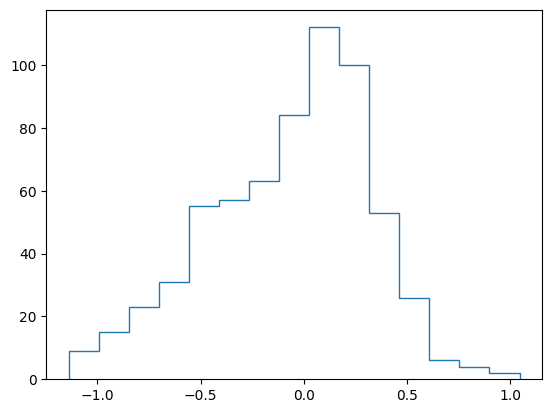

In [50]:
counts, bins = np.histogram(model.l2.weights.detach().numpy(), bins=num_bins-1)
pyplot.stairs(counts, bins)
sum(h(counts/sum(counts))) * (hidden_dim*10) / 8

In [51]:
model.l2.Q_b(num_bins - 2).detach().numpy()

array([-3, -6,  2,  1,  0,  7,  1,  4, -1, -4], dtype=int8)

<ipython-input-12-b1ed7aafea1d>:14: RuntimeWarning: divide by zero encountered in log2
  bits = np.log2(x)


3.652410118609203

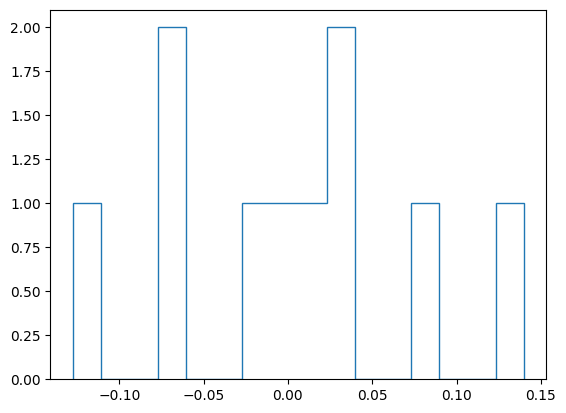

In [52]:
counts, bins = np.histogram(model.l2.bias.detach().numpy(), bins=num_bins)
pyplot.stairs(counts, bins)
sum(h(counts/sum(counts))) * 10 / 8